In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers as tfkl
from tensorflow import keras as tfk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import random
from PIL import Image
import seaborn as sns

## Load dataset

In [2]:
dataset_dir = "/kaggle/input/complex/complex/images"

batch_size = 32
img_height = 48
img_width = 48


In [3]:
train_ds,val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels = 'inferred',
    image_size=(img_height, img_width),
    batch_size=32,
    shuffle=True,
    seed=123,
    validation_split = 0.2,
    subset = 'both',
    label_mode='categorical',
    color_mode='rgb',

)


Found 6942 files belonging to 3 classes.
Using 5554 files for training.
Using 1388 files for validation.


In [4]:
class_names = train_ds.class_names
class_names

['left', 'right', 'straight']

### Rescale to [0,1]

In [5]:
def rescale(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def inverse_rescale(image, label):
    image = tf.cast(image, tf.float32) * 255.0
    return image, label

train_ds = train_ds.map(rescale)
val_ds = val_ds.map(rescale)

## Visualize example images

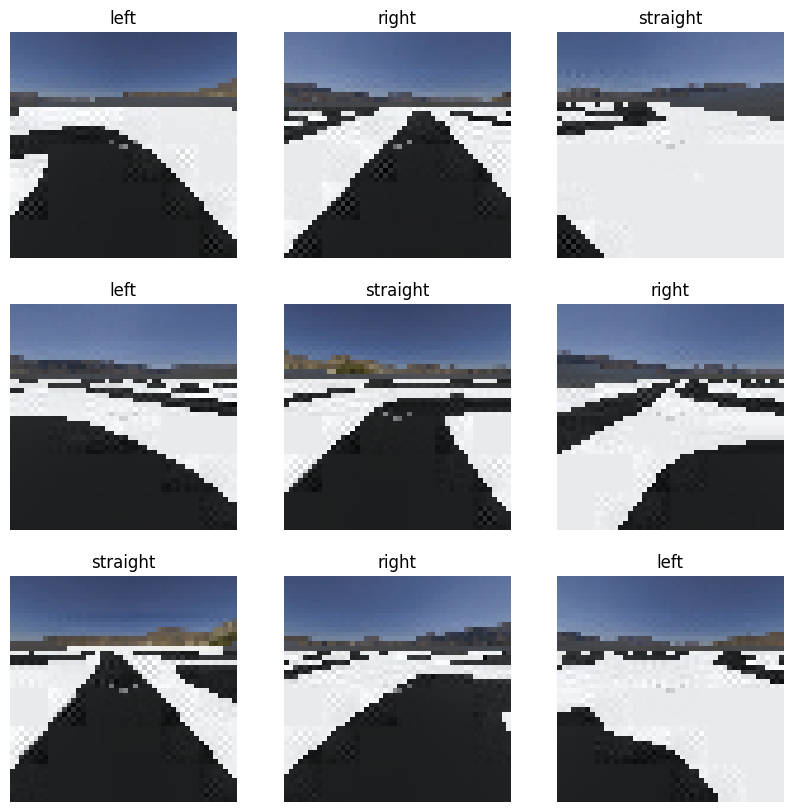

In [6]:
num_images = 9
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[tf.argmax(labels[i]).numpy()])
    plt.axis("off")
    



In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Build the net

In [8]:
num_classes = 3

def build_Net(input_shape, output_shape, seed=123):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=6,
        kernel_size=(5,5),
        padding='same',
        activation='tanh',
        name='conv1'
    )(input_layer)

    pool1 = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='mp1'
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(5,5),
        padding='valid',
        activation='tanh',
        name='conv2'
    )(pool1)

    pool2 = tfkl.MaxPooling2D(
        pool_size =(2,2),
        name='mp2'
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=24,
        kernel_size=(5,5),
        padding='valid',
        activation='tanh',
        name='conv3'
    )(pool2)

    pool3 = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='mp3'
    )(conv3)

    flattening_layer=tfkl.Flatten(
        name='flatten'
    )(pool3)

    classifier_layer=tfkl.Dense(
        units=120,
        activation='tanh',
        name='dense1'
    )(flattening_layer)

    classifier_layer = tfkl.Dense(
        units=84,
        activation='tanh',
        name='dense2'
    )(classifier_layer)

    output_layer = tfkl.Dense(
        units=output_shape,
        activation='softmax',
        name='Output'
    )(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='Net')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

In [9]:
model = build_Net((48,48,3), 3)
model.summary()

Model: "Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 48, 48, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp1 (MaxPooling2D)              │ (None, 24, 24, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 20, 20, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp2 (MaxPooling2D)              │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 6, 6, 24)       │         9,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp3 (MaxPooling2D)              │ (None, 3, 3, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 216)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 120)            │        26,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 3)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,955 (191.23 KB)

 Trainable params: 48,955 (191.23 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

history =model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=200,
  batch_size=batch_size,
  callbacks=[early_stopping]
).history

model.save('my_net.keras')

Epoch 1/200
 12/174 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4366 - loss: 1.0539

I0000 00:00:1724140298.667434      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


174/174 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.6874 - loss: 0.7243 - val_accuracy: 0.7709 - val_loss: 0.5856
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7905 - loss: 0.5252 - val_accuracy: 0.7990 - val_loss: 0.5246
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8119 - loss: 0.4767 - val_accuracy: 0.8033 - val_loss: 0.5005
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8187 - loss: 0.4445 - val_accuracy: 0.8112 - val_loss: 0.4904
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8370 - loss: 0.4103 - val_accuracy: 0.8184 - val_loss: 0.4850
Epoch 6/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8542 - loss: 0.3735 - val_accuracy: 0.8307 - val_loss: 0.4839
Epoch 7/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8620 - loss: 0.3409 - val_accuracy: 0.8314 - val_loss: 0.4947
Epoch 8/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8741 - loss: 0.3190 - val_accuracy: 0.82

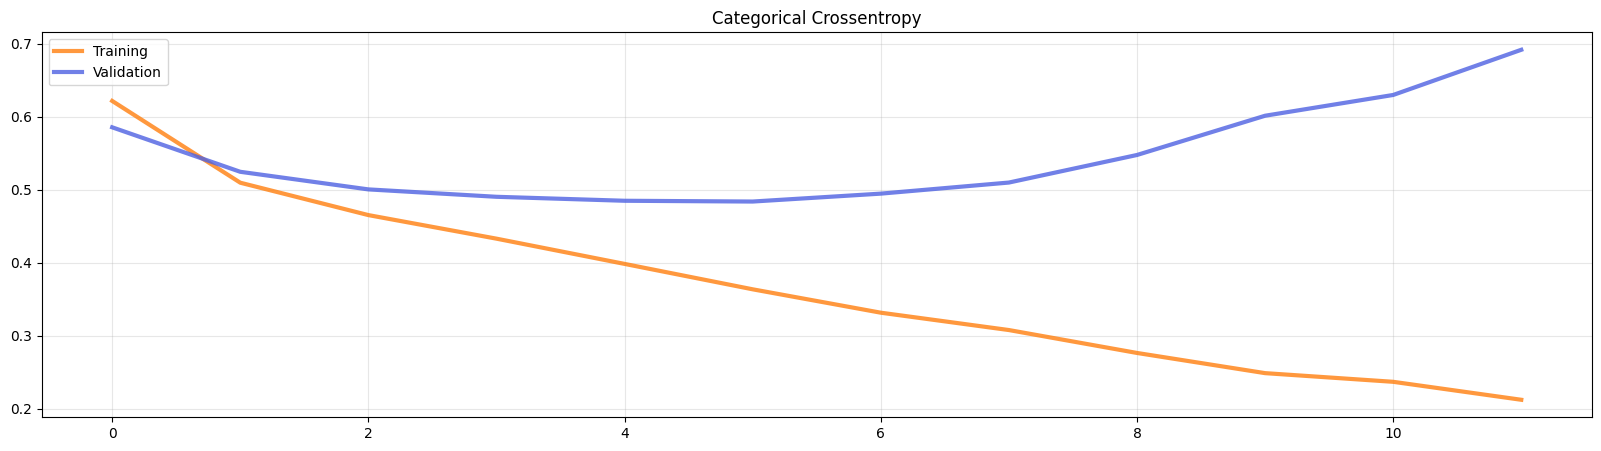

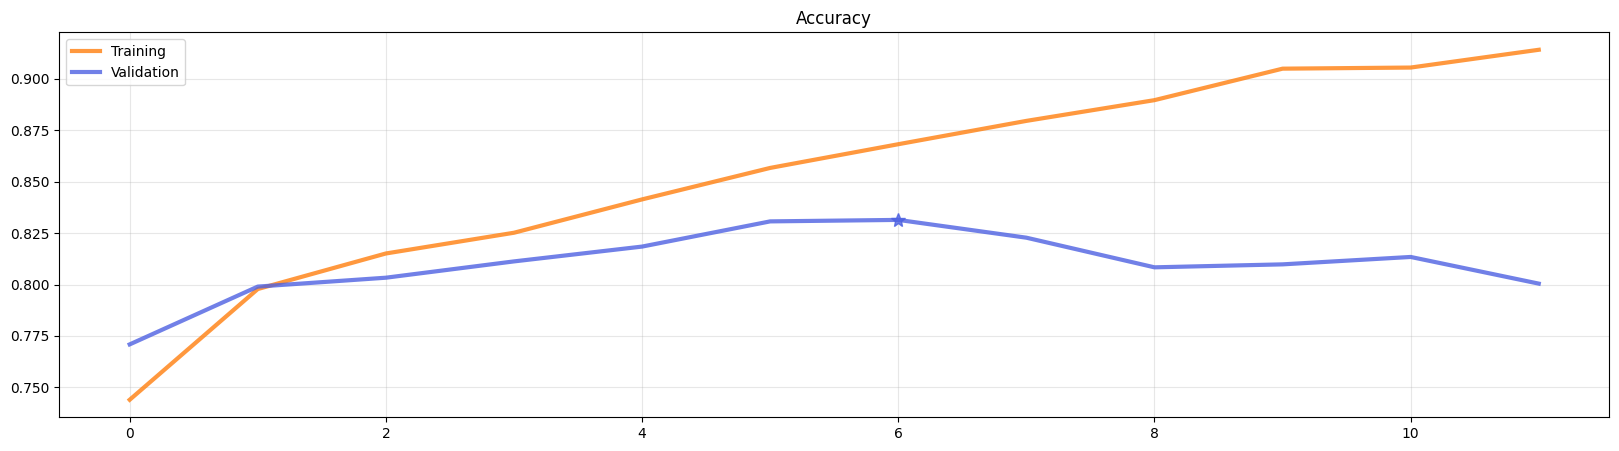

In [11]:
best_epoch = np.argmax(history['val_accuracy'])

plt.figure(figsize=(20, 5))

plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [12]:
model = tfk.models.load_model('my_net.keras')

In [13]:
model.layers

[<InputLayer name=Input, built=True>,
 <Conv2D name=conv1, built=True>,
 <MaxPooling2D name=mp1, built=True>,
 <Conv2D name=conv2, built=True>,
 <MaxPooling2D name=mp2, built=True>,
 <Conv2D name=conv3, built=True>,
 <MaxPooling2D name=mp3, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense1, built=True>,
 <Dense name=dense2, built=True>,
 <Dense name=Output, built=True>]

## Load an example Image

In [14]:
image = Image.open('/kaggle/input/complex/complex/images/right/image10078.jpg')

label = 'right'

## Visualize the prediction and first activations maps

Input image


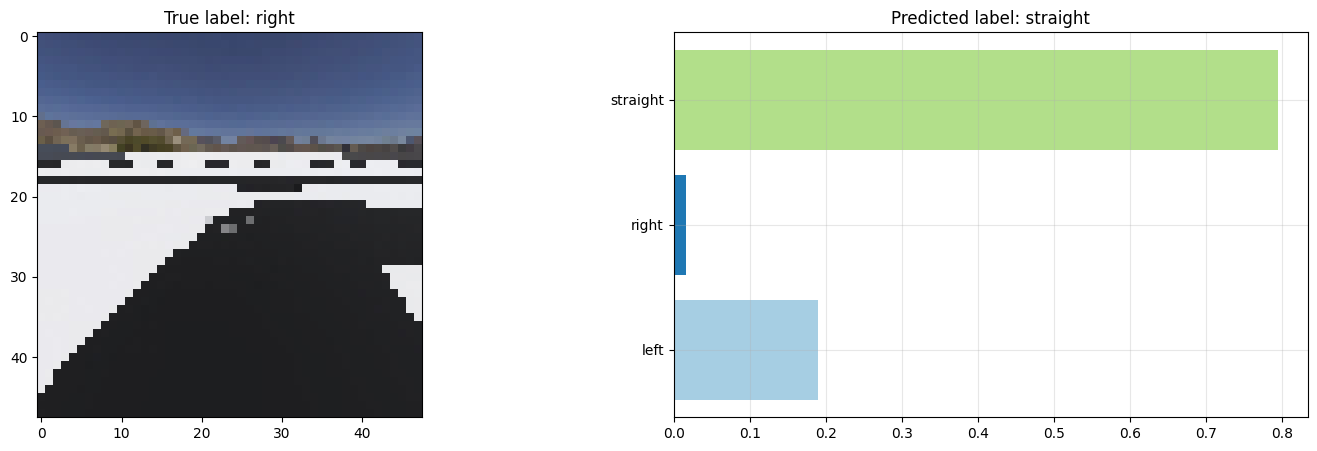

First activation maps


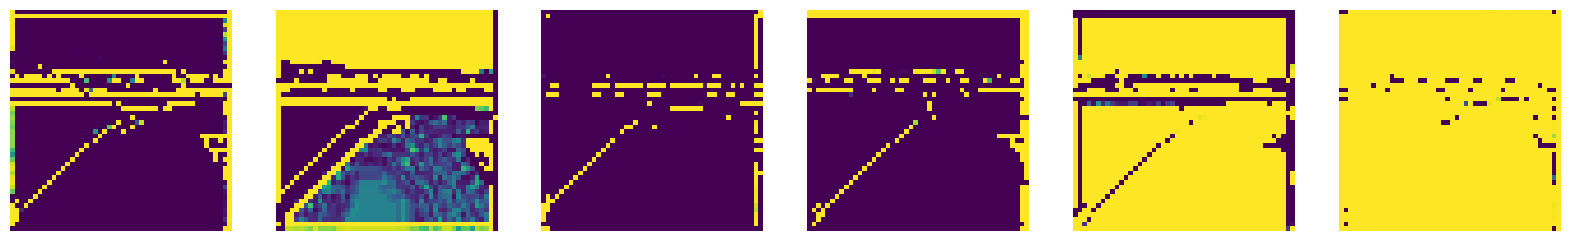

In [15]:
first_activations = tf.keras.Sequential(model.layers[:2])
            
# Add batch dimension for compatibility
feature_maps = first_activations(tf.expand_dims(image, axis=0))
        
# Remove batch dimension
feature_maps = tf.squeeze(feature_maps, axis=0)



# Display the input image, true label, and predicted label
print('Input image')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)
ax1.imshow(image)
ax1.set_title(f'True label: {label}')
prediction = model.predict(np.expand_dims(image, axis=0), verbose=0)
ax2.barh(class_names, np.squeeze(prediction, axis=0), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + class_names[np.argmax(prediction)])
ax2.grid(alpha=0.3)
plt.show()
print('First activation maps')
# Plot each channel
num_channels = feature_maps.shape[-1]
fig, axes = plt.subplots(1, num_channels, figsize=(20, 20))

for j in range(num_channels):
    ax = axes[j] if num_channels > 1 else axes
    ax.imshow(feature_maps[..., j])  # Or choose another colormap
    ax.axis('off')
       
plt.show()


## confusion matrix

In [16]:
def accuracy_per_class(model):
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    y_pred = np.argmax(y_pred, axis=1) 
    y_true = np.argmax(y_true, axis=1)
    cnt = 0
    prd = 0 
    labels = [0,1,2]
    for val in labels:
        cnt = 0
        prd = 0
        for val_true,val_predict in zip(y_true,y_pred):
            if val_true == val:
                cnt +=1
                if val_true == val_predict:
                    prd +=1
    
        print(f'Label {val} accuracy: {prd/cnt}')


In [17]:
accuracy_per_class(model)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Label 0 accuracy: 0.9221311475409836
Label 1 accuracy: 0.9
Label 2 accuracy: 0.6590909090909091


In [18]:
def print_confusion_matrix(model):
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    y_pred = np.argmax(y_pred, axis=1) 
    y_true = np.argmax(y_true, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


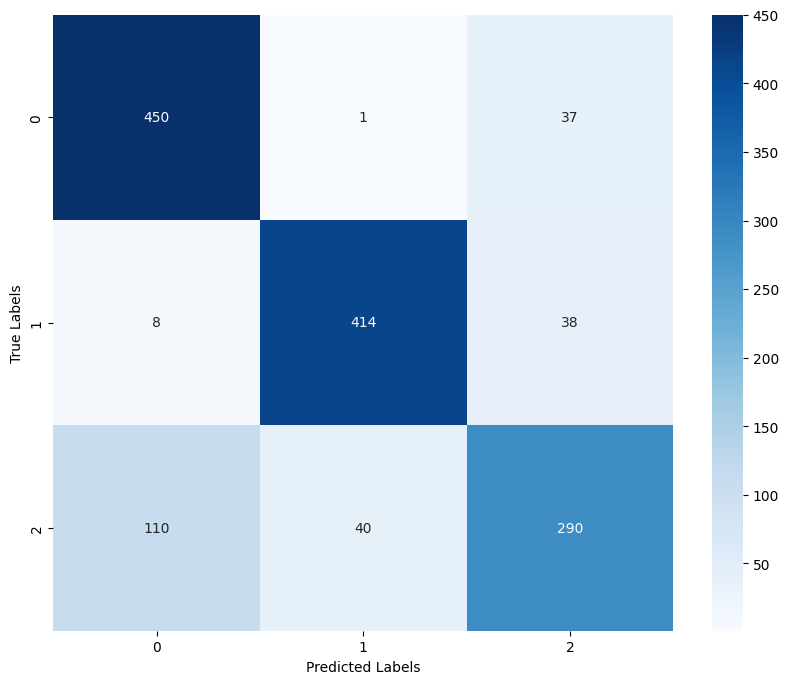

In [19]:
print_confusion_matrix(model)


## obtain activation maps

In [20]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels = 'inferred',
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    label_mode='categorical',
    color_mode='rgb',

)

ds = ds.map(rescale)

Found 6942 files belonging to 3 classes.


True label left


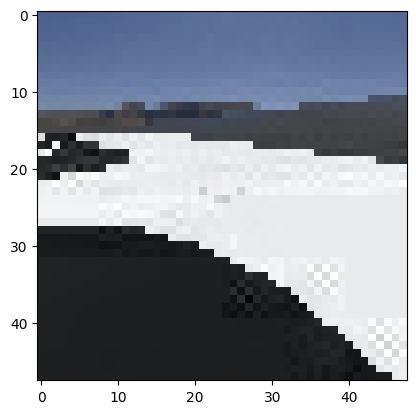

1 Convolutional Layer


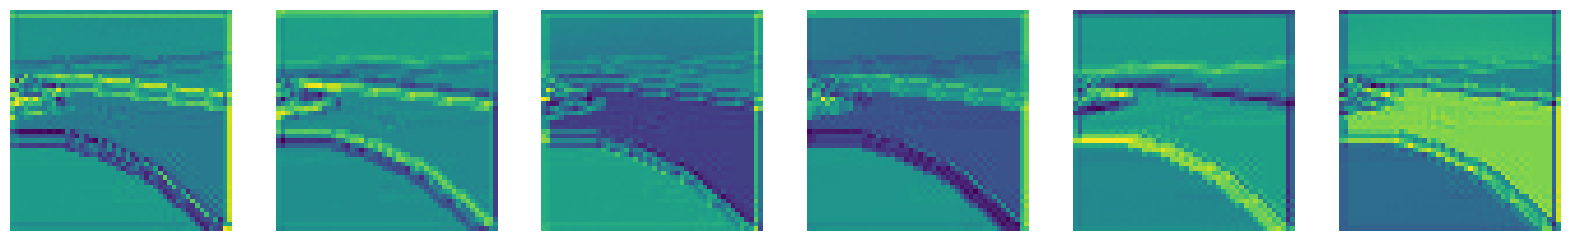

2 Convolutional Layer


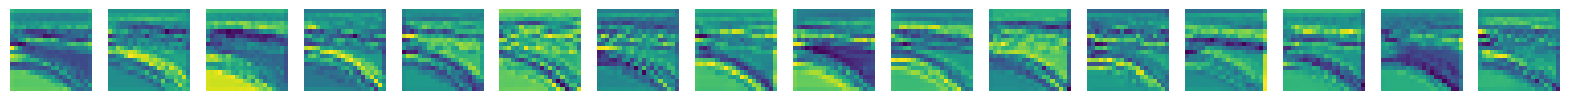

3 Convolutional Layer


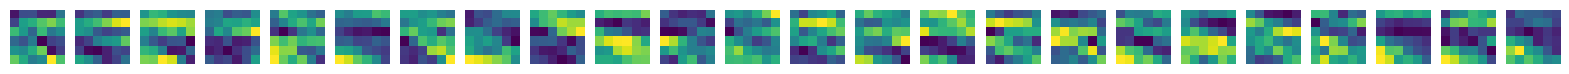

In [21]:
image_index = random.randint(0, batch_size-1)

for images, labels in ds.take(1):
    print(f'True label {class_names[np.argmax(labels[image_index])]}')
    plt.imshow(images[image_index])
    plt.show()
    for i,layer in enumerate(model.layers):
        if 'conv' in layer.name:
            print(f'{i//2+1} Convolutional Layer')        
            conv_layer = tf.keras.Sequential(model.layers[:i+1])
            
            # Add batch dimension for compatibility
            feature_maps = conv_layer(tf.expand_dims(images[image_index], axis=0))
        
            # Remove batch dimension
            feature_maps = tf.squeeze(feature_maps, axis=0)
        
            # Plot each channel
            num_channels = feature_maps.shape[-1]
            fig, axes = plt.subplots(1, num_channels, figsize=(20, 20))

            for j in range(num_channels):
                ax = axes[j] if num_channels > 1 else axes
                ax.imshow(feature_maps[..., j], cmap='viridis')  # Or choose another colormap
                ax.axis('off')
        
            plt.show()
        
        


## Efficient Net


In [22]:
train_ds = train_ds.map(inverse_rescale)
val_ds = val_ds.map(inverse_rescale)

In [23]:
# Create EfficientNetV2S model with specified settings
## INPUT IS [0-255] WARNING
efficientnet = tfk.applications.EfficientNetV2S(
    input_shape=(48, 48, 3),
    include_top=False,
    weights=None,
    pooling='avg',
    include_preprocessing=True
)


In [24]:
# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=(48, 48, 3))
# Connect EfficientNetV2S to the input
x = efficientnet(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(3, activation='softmax')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,335,203 (77.57 MB)

 Trainable params: 20,181,331 (76.99 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [25]:
history = model.fit(
    train_ds,
    batch_size = 32,
    epochs = 200,
    validation_data = val_ds,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=7, restore_best_weights=True)]
).history

Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.6269 - loss: 0.9316 - val_accuracy: 0.7903 - val_loss: 0.5906
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.7753 - loss: 0.5896 - val_accuracy: 0.7961 - val_loss: 0.5407
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.7933 - loss: 0.5454 - val_accuracy: 0.8220 - val_loss: 0.4971
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.8183 - loss: 0.4915 - val_accuracy: 0.7947 - val_loss: 0.5488
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.8150 - loss: 0.5038 - val_accuracy: 0.8206 - val_loss: 0.4911
Epoch 6/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.8208 - loss: 0.4836 - val_accuracy: 0.8098 - val_loss: 0.5041
Epoch 7/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.8409 - loss: 0.4390 - val_accuracy: 0.8199 - val_loss: 0.5054
Epoch 8/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.8408 - loss: 0.

In [26]:
model.save('Efficient.keras')

## Transfer Learning

In [27]:
efficientnet = tfk.applications.EfficientNetV2S(
    input_shape=(48, 48, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing=True
)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [28]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
efficientnet.trainable = False

# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=(48, 48, 3))
# Connect EfficientNetV2S to the input
x = efficientnet(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(3, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,335,203 (77.57 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [29]:
tl_history = tl_model.fit(
    train_ds,
    batch_size = 32,
    epochs = 200,
    validation_data = val_ds,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history

Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 152s 426ms/step - accuracy: 0.5058 - loss: 1.0241 - val_accuracy: 0.6419 - val_loss: 0.8630
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6259 - loss: 0.8712 - val_accuracy: 0.6722 - val_loss: 0.8096
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6587 - loss: 0.8260 - val_accuracy: 0.6866 - val_loss: 0.7796
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6688 - loss: 0.7996 - val_accuracy: 0.7039 - val_loss: 0.7570
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6778 - loss: 0.7851 - val_accuracy: 0.7089 - val_loss: 0.7403
Epoch 6/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6753 - loss: 0.7713 - val_accuracy: 0.7140 - val_loss: 0.7253
Epoch 7/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6876 - loss: 0.7602 - val_accuracy: 0.7190 - val_loss: 0.7174
Epoch 8/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6909 - loss: 0.7503

In [30]:
tl_model.save('TransferLearningModel.keras')

## Fine tuning

In [31]:
ft_model = tfk.models.load_model('TransferLearningModel.keras')
ft_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,342,891 (77.60 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

 Optimizer params: 7,688 (30.04 KB)

In [32]:
ft_model.get_layer('efficientnetv2-s').trainable = True
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers):
   print(i, layer.name, layer.trainable)

0 input_layer_2 True
1 rescaling_1 True
2 stem_conv True
3 stem_bn True
4 stem_activation True
5 block1a_project_conv True
6 block1a_project_bn True
7 block1a_project_activation True
8 block1a_add True
9 block1b_project_conv True
10 block1b_project_bn True
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block2a_expand_conv True
15 block2a_expand_bn True
16 block2a_expand_activation True
17 block2a_project_conv True
18 block2a_project_bn True
19 block2b_expand_conv True
20 block2b_expand_bn True
21 block2b_expand_activation True
22 block2b_project_conv True
23 block2b_project_bn True
24 block2b_drop True
25 block2b_add True
26 block2c_expand_conv True
27 block2c_expand_bn True
28 block2c_expand_activation True
29 block2c_project_conv True
30 block2c_project_bn True
31 block2c_drop True
32 block2c_add True
33 block2d_expand_conv True
34 block2d_expand_bn True
35 block2d_expand_activation True
36 block2d_project_conv True
37 block2d_project_bn True
38 block2

In [33]:
# Freeze first N layers, e.g., until the 286th one
N = 286
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_layer_2 False
1 rescaling_1 False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block2d_expand_conv False
34 block2d_expand_bn False
35 block2d_expand_activation False
36 block2d_project_conv False

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,342,891 (77.60 MB)

 Trainable params: 14,895,915 (56.82 MB)

 Non-trainable params: 5,439,288 (20.75 MB)

 Optimizer params: 7,688 (30.04 KB)

In [34]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])

In [35]:
# Fine-tune the model
ft_history = ft_model.fit(
    train_ds,
    batch_size = 32,
    epochs = 200,
    validation_data = val_ds,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=7, restore_best_weights=True)]
).history

Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 243s 662ms/step - accuracy: 0.5179 - loss: 1.6833 - val_accuracy: 0.6398 - val_loss: 1.1501
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6196 - loss: 1.2824 - val_accuracy: 0.6650 - val_loss: 1.0425
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.6339 - loss: 1.1775 - val_accuracy: 0.6794 - val_loss: 0.9556
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6496 - loss: 1.0284 - val_accuracy: 0.6880 - val_loss: 0.8982
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6565 - loss: 0.9838 - val_accuracy: 0.7046 - val_loss: 0.8571
Epoch 6/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6766 - loss: 0.9186 - val_accuracy: 0.7133 - val_loss: 0.7946
Epoch 7/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6883 - loss: 0.8569 - val_accuracy: 0.7341 - val_loss: 0.7359
Epoch 8/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6979 - loss: 0.7642

In [36]:
ft_model.save('FineTuningModel.keras')

## Fine tune with freeze batch norm

# Re-load the model after transfer learning


In [37]:
ft_bn_model = tfk.models.load_model('TransferLearningModel.keras')
ft_bn_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,342,891 (77.60 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

 Optimizer params: 7,688 (30.04 KB)

In [38]:
# Set all EfficientNetV2S layers as trainable
ft_bn_model.get_layer('efficientnetv2-s').trainable = True
for i, layer in enumerate(ft_bn_model.get_layer('efficientnetv2-s').layers):
    if layer.name[-2:] == 'bn':
        layer.trainable=False
    print(i, layer.name, layer.trainable)

0 input_layer_2 True
1 rescaling_1 True
2 stem_conv True
3 stem_bn False
4 stem_activation True
5 block1a_project_conv True
6 block1a_project_bn False
7 block1a_project_activation True
8 block1a_add True
9 block1b_project_conv True
10 block1b_project_bn False
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block2a_expand_conv True
15 block2a_expand_bn False
16 block2a_expand_activation True
17 block2a_project_conv True
18 block2a_project_bn False
19 block2b_expand_conv True
20 block2b_expand_bn False
21 block2b_expand_activation True
22 block2b_project_conv True
23 block2b_project_bn False
24 block2b_drop True
25 block2b_add True
26 block2c_expand_conv True
27 block2c_expand_bn False
28 block2c_expand_activation True
29 block2c_project_conv True
30 block2c_project_bn False
31 block2c_drop True
32 block2c_add True
33 block2d_expand_conv True
34 block2d_expand_bn False
35 block2d_expand_activation True
36 block2d_project_conv True
37 block2d_project_bn Fals

In [39]:
# Freeze first N layers, e.g., until the 133rd one
N = 286
for i, layer in enumerate(ft_bn_model.get_layer('efficientnetv2-s').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_bn_model.get_layer('efficientnetv2-s').layers):
   print(i, layer.name, layer.trainable)
ft_bn_model.summary()

0 input_layer_2 False
1 rescaling_1 False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block2d_expand_conv False
34 block2d_expand_bn False
35 block2d_expand_activation False
36 block2d_project_conv False

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,342,891 (77.60 MB)

 Trainable params: 14,795,819 (56.44 MB)

 Non-trainable params: 5,539,384 (21.13 MB)

 Optimizer params: 7,688 (30.04 KB)

In [40]:
# Compile the model
ft_bn_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])

In [41]:
# Fine-tune the model
ft_bn_history = ft_bn_model.fit(
    train_ds,
    batch_size = 32,
    epochs = 200,
    validation_data = val_ds,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=7, restore_best_weights=True)]
).history

Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 203s 574ms/step - accuracy: 0.7246 - loss: 0.6695 - val_accuracy: 0.7450 - val_loss: 0.6226
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7502 - loss: 0.6232 - val_accuracy: 0.7558 - val_loss: 0.5992
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7611 - loss: 0.5870 - val_accuracy: 0.7673 - val_loss: 0.5754
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7630 - loss: 0.5768 - val_accuracy: 0.7615 - val_loss: 0.5776
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7660 - loss: 0.5700 - val_accuracy: 0.7716 - val_loss: 0.5560
Epoch 6/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7695 - loss: 0.5468 - val_accuracy: 0.7695 - val_loss: 0.5509
Epoch 7/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7693 - loss: 0.5419 - val_accuracy: 0.7716 - val_loss: 0.5454
Epoch 8/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7798 - loss: 0.5400

In [42]:
ft_bn_model.save('FineTuningModelFrozenBN.keras')

## Obtain the embedding(216) for each input image